# Week 14 Exercises - Dimensionality Reduction

### Determining whether PCA is useful / relevant for a given dataset

In Principal Components Analysis assume we have computed the variances (eigenvalues of the empirical covariance matrix), $\lambda_1,\dots,\lambda_d>0$.
Define $\bar{\lambda} = \frac{1}{d} \sum_{i=1}^d \lambda_i$, the mean of the variances (eigenvalues).

Now consider the following usefulness measure of PCA:

$$score = \sum_{i=1}^d (\lambda_i - \bar{\lambda})^2$$

Discuss whether $score$ could be used as a measure of whether performing a PCA would be useful. What is $score$ and what does it mean for it to be zero and what would it mean if it is large?

## PCA on digits
In this exercise we will experiment with PCA on digits.

1. Run PCA on the data (first 5000 digits) http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html (use n_components = 784). Save this PCA model in a variable to use in the subsequent exercises. Use plot_images to plot the 20 directions with largest variance (the directions can be found in the attribute ``components_``). 


2. Consider the proportion of variance explained by each principal component (see ``explain_variance_``, and ``explained_variance_ratio_``). Make a plot of the variance explained as a function of the number of principal components, i.e. x axis is number of components, $k=1, \dots, 784$  and y axis is proportion of variance explained by the first $k$ principal components in total (``np.cumsum()`` may be useful). Looking at this plot, how many components do we approximately need to get 90 percent of the variance explained?



3. Take the first 20 data points from the data and project onto the first $k$ components for $k$ in $[1, 2,4,8,16, 32, 64]$ and plot them as images. What do you see?
**Hint: See slide 27 and 28 from Wednesday's lecture.**


4. Map all the data to 2D (use only 2 principal components) and make a scatter plot where you color with the label $y \in \{0, 1, \dots, 9 \}$ and see if there is some structure. It may be helpful to use `plt.scatter` with `cmap = plt.cm.Paired`, like (`ax.scatter(x,y, c=lab, cmap=plt.cm.Paired`). 
    
    
5. Map all data to 32 Dimension and run a Classifier and output in sample accuracy. (How should you select target dimension in real life?). You can use any classifier you want (we have already imported a support vector machines and an SGD classifier for you, e.g. use `model = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200, fit_intercept=True)`. Compare with the result and runtime you get when using the 'uncompressed' data set.


In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import torchvision.datasets as datasets

def plot_images(dat, k=20, size=28):
    """ Plot the first k vectors as 28 x 28 images """
    x2 = dat[0:k,:].reshape(-1, size, size)
    x2 = x2.transpose(1, 0, 2)
    fig, ax = plt.subplots(figsize=(20,12))
    ax.imshow(x2.reshape(size, -1), cmap='bone')
    ax.set_yticks([])
    ax.set_xticks([])
    plt.show()

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
# Load full dataset
X = mnist_trainset.train_data.numpy().reshape((60000, 28*28))
y = mnist_trainset.train_labels.numpy()

# Take out random subset
rp = np.random.permutation(len(y))
X = X[rp[:5000], :]
y = y[rp[:5000]]

### YOUR CODE HERE
### END CODE

## PCA Vs. Autoencoder

Below, we have implemented an autoencoder for you by using Torch. Remember, that autoencoders can also be used for dimensionality reduction! Reducing the size of the hidden layer will force the network to compress the data. 

If linear activations are used, then the optimal solution to an autoencoder is strongly related to PCA. The weights of the autoencoder span the same vector subspace as the one spanned by the first $h$ principal components, and the output of the autoencoder is an orthogonal projection onto this subspace. The autoencoder weights are not equal to the principal components, and are generally not orthogonal, yet the principal components may be recovered from them using singular value decomposition.

We have visualized the encoding and decoding matrix for you. You can experiment with different activation functions, hidden layer size and perhaps regularization techniques such as weight decay.

In [15]:
## Cell for training the autoencoder

import os
import urllib
import urllib.request
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

class DigitsDataset(Dataset):
    """ example of how to make a pytorch data set """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float()

    
train_data = DigitsDataset(X, y)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)


class Net(nn.Module):
    def __init__(self, h):
        super(Net, self).__init__()
        self.W1 = nn.Linear(784, h)
        self.W2 = nn.Linear(h, 784)
        
    def forward(self, x):
        # h1 = F.relu(self.W1(x)) You can try relu if you want
        h1 = self.W1(x)
        return self.W2(h1)

h = 64  # Set hidden layer size here
net = Net(h)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 50
for epoch in range(epochs):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(data)
        cur_loss = loss(outputs, data)
        cur_loss.backward()
        optimizer.step()
    if epoch % 20 == 0:
        print('Epoch %d, loss: %.3f' % (epoch + 1, cur_loss.item()))
        
print('Finished Training - lets plot some encodings')

Epoch 1, loss: 3415.350
Epoch 21, loss: 586.641
Epoch 41, loss: 480.900
Finished Training - lets plot some encodings


Encoding matrix (64, 784)


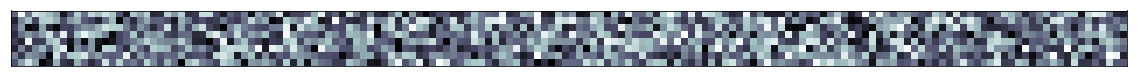

Decoding matrix (784, 64)


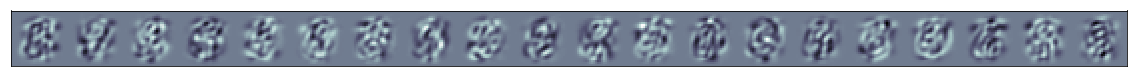

Encoded images (20, 64)


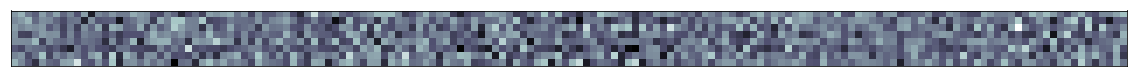

Decoded images (20, 784)


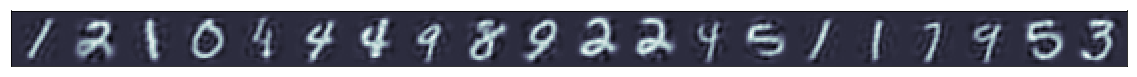

Original images


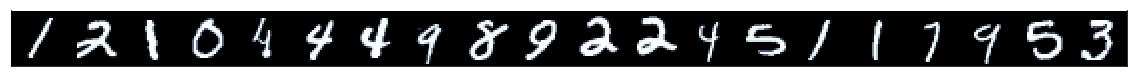

In [16]:
# Plot the results
with torch.no_grad():
    compressed_size = int(np.sqrt(h))
    
    W1 = net.W1.weight.detach().numpy()
    print("Encoding matrix", W1.shape)
    plot_images(W1.T, size=compressed_size)
    W2 = net.W2.weight.detach().numpy()
    print("Decoding matrix", W2.shape)
    plot_images(W2.T, size=28)
    
    batch = next(iter(train_loader)).numpy()[:20]
    enc_batch = batch @ W1.T
    print("Encoded images", enc_batch.shape)
    plot_images(enc_batch, size=compressed_size)
    
    dec_batch = enc_batch @ W2.T
    print("Decoded images", dec_batch.shape)
    plot_images(dec_batch, size=28)
    print("Original images")
    plot_images(batch, size=28)